In [63]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.stats import gamma, describe
import os, sys, pickle

import genexpr
from genexpr.twostagemodel import TwoStageModel
from genexpr.threestagemodel import ThreeStageModel
from genexpr.utils import KL_div, NBinom

params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
         'axes.titlesize':25}
pylab.rcParams.update(params)

# Part 1: Simulation of paper results
## Two-stage model

- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$

In [19]:
twostage = TwoStageModel()

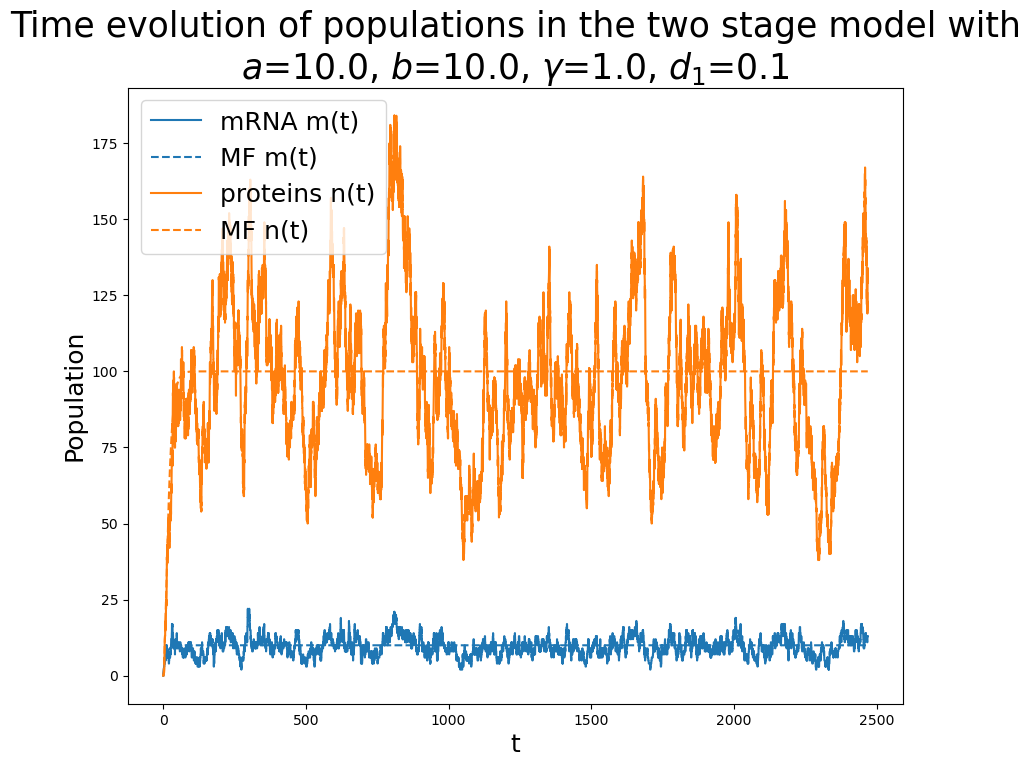

In [23]:
# initializations
t = 0.0
x = np.array([0,0])

nu0, d0, nu1, d1 = 1, 0.1, 1, 0.1
args = [nu0, d0, nu1, d1]
gamma, a, b =  d0/d1, nu0/d1, nu1/d0

# Gillespie iterations
tstat=2.0e3
(m_t, n_t), t_t = twostage.Gillespie_simulation(x, t, tstat, 10000, args, keep_transient=True)


# Mean field solution
m_MF_t, n_MF_t = twostage.mean_field_prediction(np.array([0,0]), t_t, args)


# plots
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(t_t, m_t, label="mRNA m(t)")
ax.plot(t_t, m_MF_t, "--", color="C0", label="MF m(t)")
ax.plot(t_t, n_t, label="proteins n(t)")
ax.plot(t_t, n_MF_t, "--", color="C1", label="MF n(t)")

ax.set_title("Time evolution of populations in the two stage model with\n" + fr"$a$={a}, $b$={b}, $\gamma$={gamma}, $d_1$={d1}")
ax.set_xlabel("t")
ax.set_ylabel("Population")
ax.legend()
fig.savefig("images/twostage_transient.jpg", dpi=150)

### Figure 1B


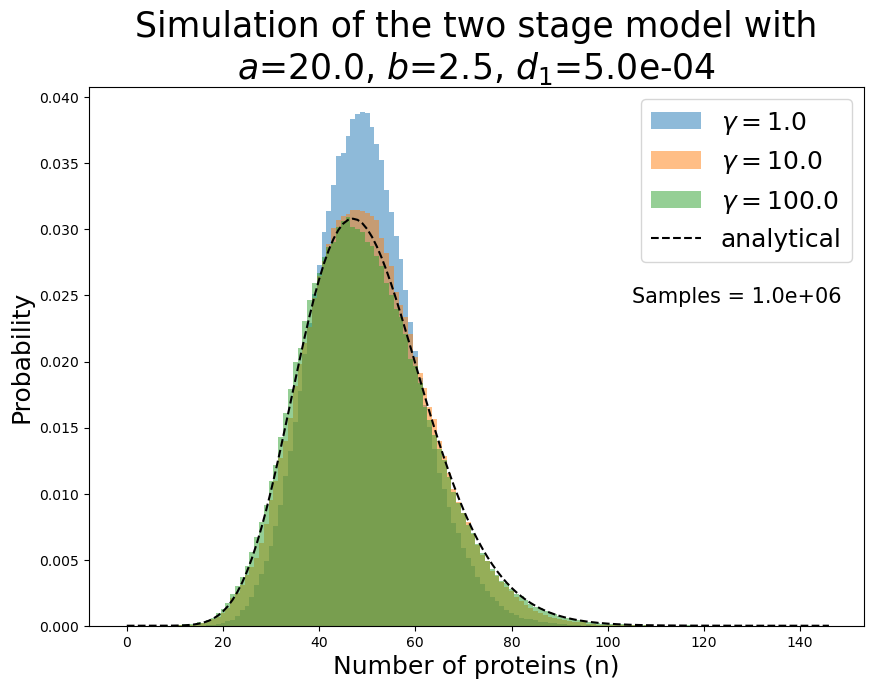

In [38]:
a_target = 20.0
N_target = int(1e6)
max_n = -1
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig1bd/")):
    if not filename.startswith('.'):
        with open("results/fig1bd/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(res["args_gamma_a_b_d1"][1], a_target) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1 = res["args_gamma_a_b_d1"]
            args = res["args"]
            tstat = res["tmax"]
            taustat = res["tau_max"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            # histogram
            h_, n_, _ = ax.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.5)
            max_n = max(max_n, max(n_hist))



# analytical plot
n0 = np.arange(max_n+10)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
ax.plot(n0, fn_analytical, "--", c="black", label="analytical")
ax.set_title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1:.1e}")
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.text(0.7, 0.6, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/twostage_1b.jpg", dpi=150)

### Figure 1C


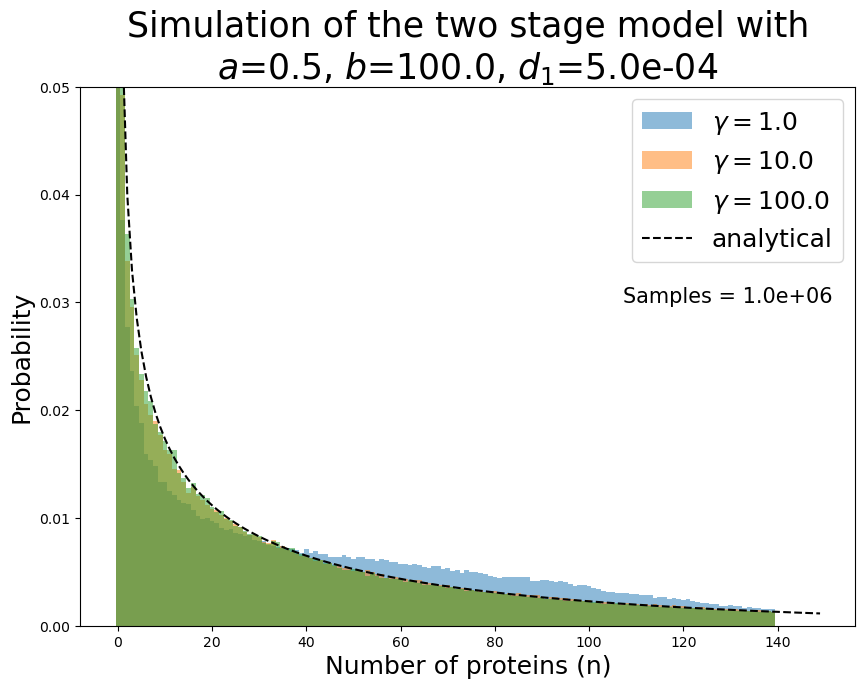

In [39]:
a_target = 0.5
N_target = int(1e6)
max_n = 140
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig1bd/")):
    if not filename.startswith('.'):
        with open("results/fig1bd/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(res["args_gamma_a_b_d1"][1], a_target) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1 = res["args_gamma_a_b_d1"]
            args = res["args"]
            tstat = res["tmax"]
            taustat = res["tau_max"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            # histogram
            h_, n_, _ = ax.hist(n_hist, bins=np.arange(start=-0.5, stop=max_n+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.5)



# analytical plot
n0 = np.arange(max_n+10)
fn_analytical = twostage.analytical_stationary(n0, args, normalize=True)
ax.plot(n0, fn_analytical, "--", c="black", label="analytical")
ax.set_title("Simulation of the two stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1:.1e}")
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.set_ylim(0,0.05)
ax.text(0.7, 0.6, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/twostage_1c.jpg", dpi=150)

### Figure 1D

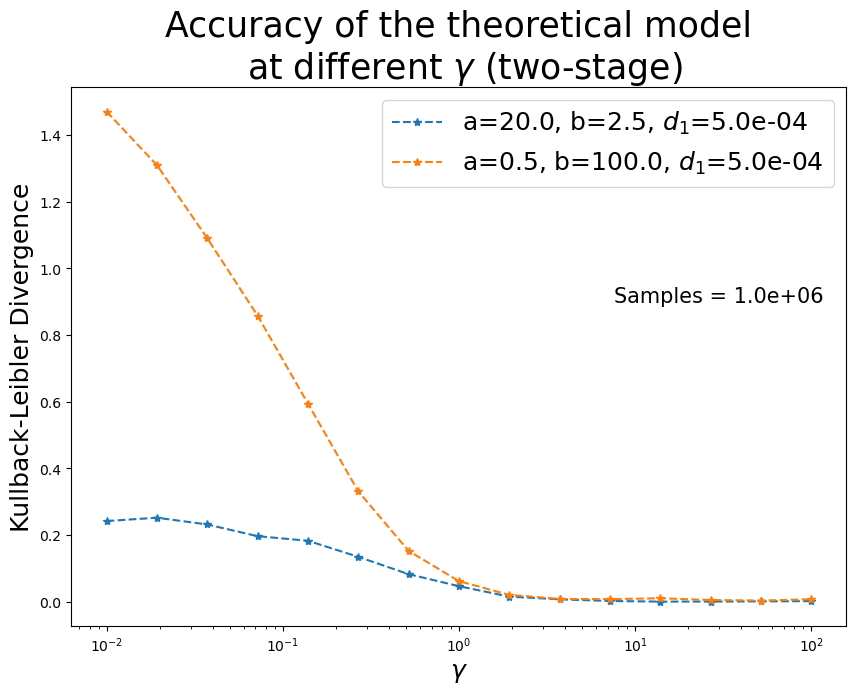

In [58]:
N_target = int(1e6)
KL_divs = {}
args_red_list = []
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig1d/")):
    if not filename.startswith('.'):
        with open("results/fig1d/"+filename, 'rb') as file:
            res = pickle.load(file)

            if res["N_iters"] != N_target:
                continue

            # read arguments from pickle
            gamma, a, b, d1 = res["args_gamma_a_b_d1"]
            args = res["args"]
            tstat = res["tmax"]
            taustat = res["tau_max"]
            x0 = res["x0"]
            t0 = res["t0"]
            

            if f"{a}_{b}" not in KL_divs.keys():
                args_red_list.append((a, b, d1))
                KL_divs[f"{a}_{b}"] = {"D_KL":[], "gamma":[]}
            
            KL_divs[f"{a}_{b}"]["D_KL"].append(res["D_KL"])
            KL_divs[f"{a}_{b}"]["gamma"].append(gamma)

# plot curves
for a_,b_,_ in args_red_list:
    ax.plot(KL_divs[f"{a_}_{b_}"]["gamma"], KL_divs[f"{a_}_{b_}"]["D_KL"], "*--", label=f"a={a_}, b={b_}, $d_1$={d1:.1e}")

ax.set_title("Accuracy of the theoretical model\n at different $\gamma$ (two-stage)")
ax.set_xscale("log")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("Kullback-Leibler Divergence")
ax.text(0.7, 0.6, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/twostage_1d.jpg", dpi=150)

### Figure 2A

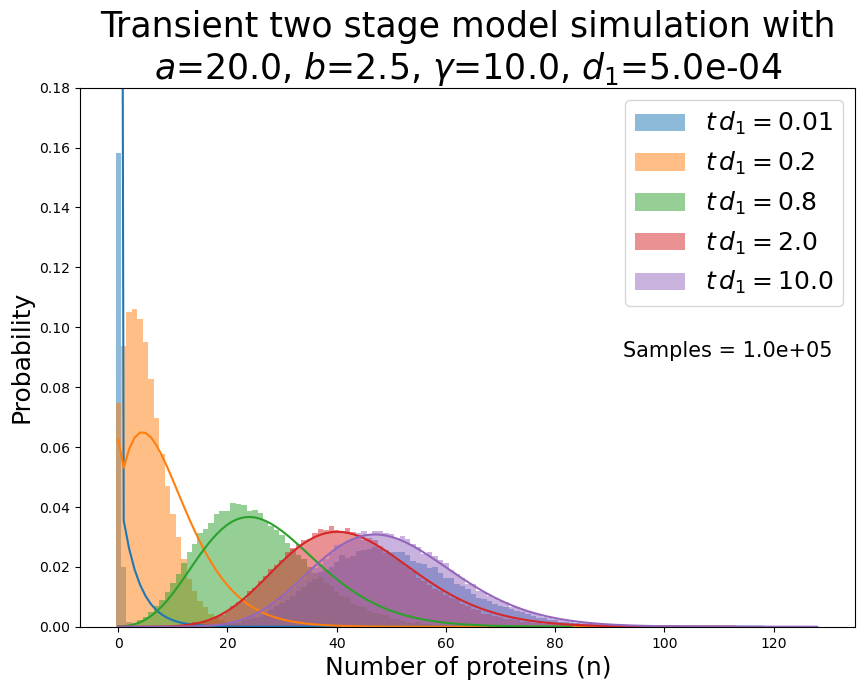

In [55]:
a_target = 20.0
N_target = int(1e5)
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig2ab/")):
    if not filename.startswith('.'):
        with open("results/fig2ab/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(a_target, res["args_gamma_a_b_d1"][1]) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1 = res["args_gamma_a_b_d1"]
            args = res["args"]
            tau_slices = res["tau_slices"]
            tslices = res["tslices"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            for t_, n_t in enumerate(n_hist):
                ax.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tau_slices[t_], 2)}")
                n0 = np.arange(max(n_t))
                ax.plot(n0, twostage.analytical_transient(n0, tslices[t_], np.identity(1)[0,:], args=args, normalize=True), ls="-", c="C"+str(t_))

            
ax.set_title("Transient two stage model simulation with\n" + fr"$a$={a}, $b$={b}, $\gamma$={gamma}, $d_1$={d1:.1e}")
ax.set_ylim(0,0.18)
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.text(0.7, 0.5, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/twostage_2a.jpg", dpi=150)

### Figure 2B

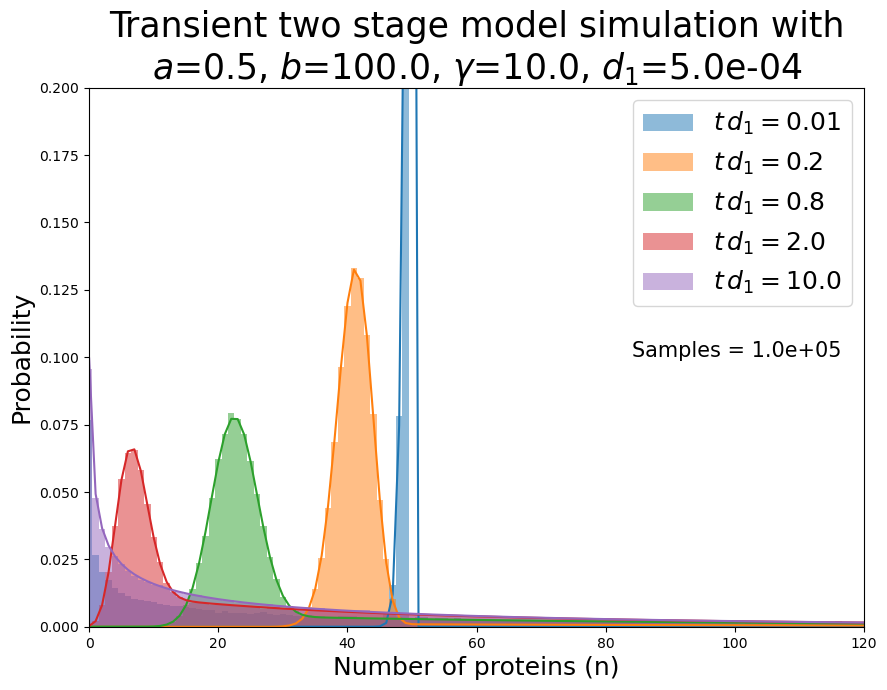

In [57]:
a_target = 0.5
N_target = int(1e5)
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig2ab/")):
    if not filename.startswith('.'):
        with open("results/fig2ab/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(a_target, res["args_gamma_a_b_d1"][1]) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1 = res["args_gamma_a_b_d1"]
            args = res["args"]
            tau_slices = res["tau_slices"]
            tslices = res["tslices"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            for t_, n_t in enumerate(n_hist):
                ax.hist(n_t, bins=np.arange(start=-0.5, stop=max(n_t)+0.5, step=1), density=True, alpha=0.5, label=f"$t\, d_1 = ${np.round(tau_slices[t_], 2)}")
                n0 = np.arange(max(n_t))
                ax.plot(n0, twostage.analytical_transient(n0, tslices[t_], np.identity(x0[1]+1)[x0[1],:], args=args, normalize=True), ls="-", c="C"+str(t_))

            
ax.set_title("Transient two stage model simulation with\n" + fr"$a$={a}, $b$={b}, $\gamma$={gamma}, $d_1$={d1:.1e}")
ax.set_ylim(0,0.2)
ax.set_xlim(0,120)
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.text(0.7, 0.5, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/twostage_2b.jpg", dpi=150)

### Figure 2C

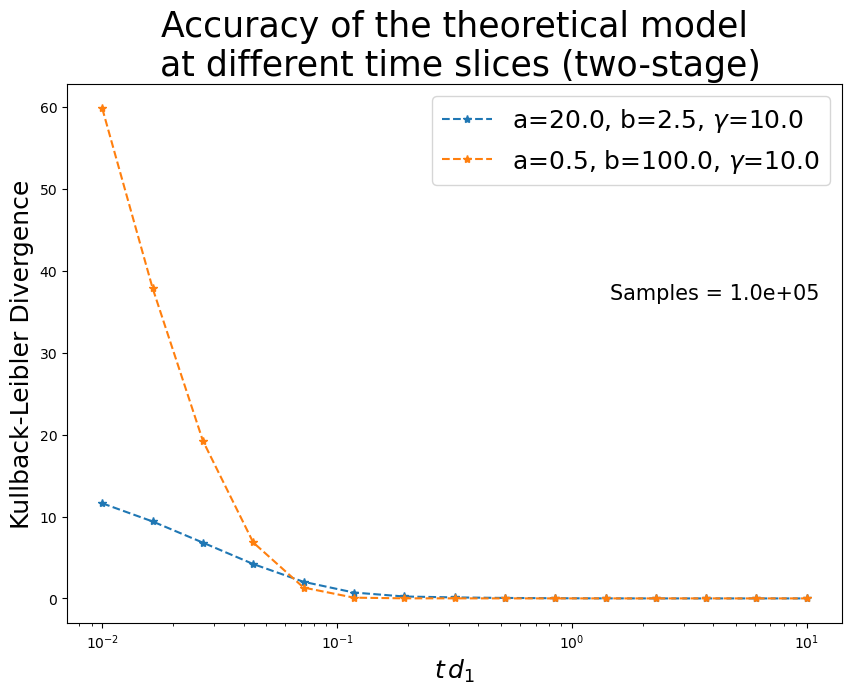

In [34]:
N_target = int(1e5)
max_n = 140
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig2c/")):
    if not filename.startswith('.'):
        with open("results/fig2c/"+filename, 'rb') as file:
            res = pickle.load(file)

            if res["N_iters"] != N_target:
                continue

            # read arguments from pickle
            gamma, a, b, d1 = res["args_gamma_a_b_d1"]
            args = res["args"]
            taus = res["taus"]
            x0 = res["x0"]
            t0 = res["t0"]
            KL_divs = res["D_KL"]
            

            # plot curve
            ax.plot(taus, KL_divs, "*--", label=f"a={a}, b={b}, $\gamma$={gamma}")

ax.set_title("Accuracy of the theoretical model\n at different time slices (two-stage)")
ax.set_xscale("log")
ax.set_xlabel("$t\, d_1$")
ax.set_ylabel("Kullback-Leibler Divergence")
ax.text(0.7, 0.6, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/twostage_2c.jpg", dpi=150)

### Figure 2D

In [65]:
taus = np.linspace(0, 5, num=20)
gamma, a, b, d1 = 10.0, 20.0, 2.5, 5e-4
mu_ = 50
noises = np.linspace(0.2, 1.0, num=9)
eta_stat = np.sqrt((1+b)/(a*b))
res = {}

for eta_ in noises:
    res[f"eta0_{eta_}"] = {"eta":[], "tau":[]}

    for tau_ in taus:
        args = (a*d1, gamma*d1, b*gamma*d1, d1)

        n0 = np.arange(150)
        fn_analytical = twostage.analytical_transient(n0, tau_/d1, NBinom(n0, mu_, eta_), args, normalize=True)
        mean_dist = np.average(n0, weights=fn_analytical)
        std_dist = np.sqrt(np.average((n0-mean_dist)**2, weights=fn_analytical))
        plt.clf()

        res[f"eta0_{eta_}"]["eta"].append(std_dist/mean_dist)
        res[f"eta0_{eta_}"]["tau"].append(tau_)

<Figure size 640x480 with 0 Axes>

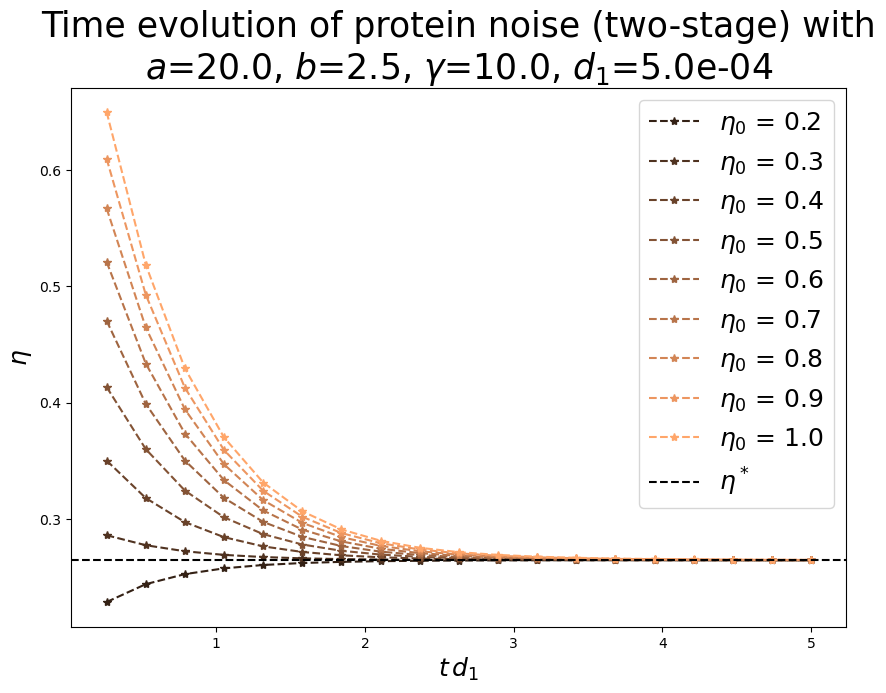

In [72]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
cmap = mpl.colormaps["copper"]
for eta_ in noises:
    data = res[f"eta0_{eta_}"]
    ax.plot(data["tau"], data["eta"], "*--", label=f"$\eta_0$ = {round(eta_,2)}", color=cmap(eta_/(1.2*max(noises))))

ax.axhline(eta_stat, c="k", ls="--", label="$\eta^*$")
ax.set_title("Time evolution of protein noise (two-stage) with\n" + fr"$a$={a}, $b$={b}, $\gamma$={gamma}, $d_1$={d1:.1e}")
ax.set_xlabel("$t\, d_1$")
ax.set_ylabel("$\eta$")
ax.legend()
fig.savefig("images/twostage_2d.jpg", dpi=150)

## Three-stage model
- $a = \nu_0 / d_1$
- $b = \nu_1 / d_0$
- $\gamma = d_0 / d_1$
- $\tau = d_1 t$
- $\kappa_0 = K_0/d_1$
- $\kappa_1 = K_1/d_1$

In [74]:
threestage = ThreeStageModel()

### Figure 3B

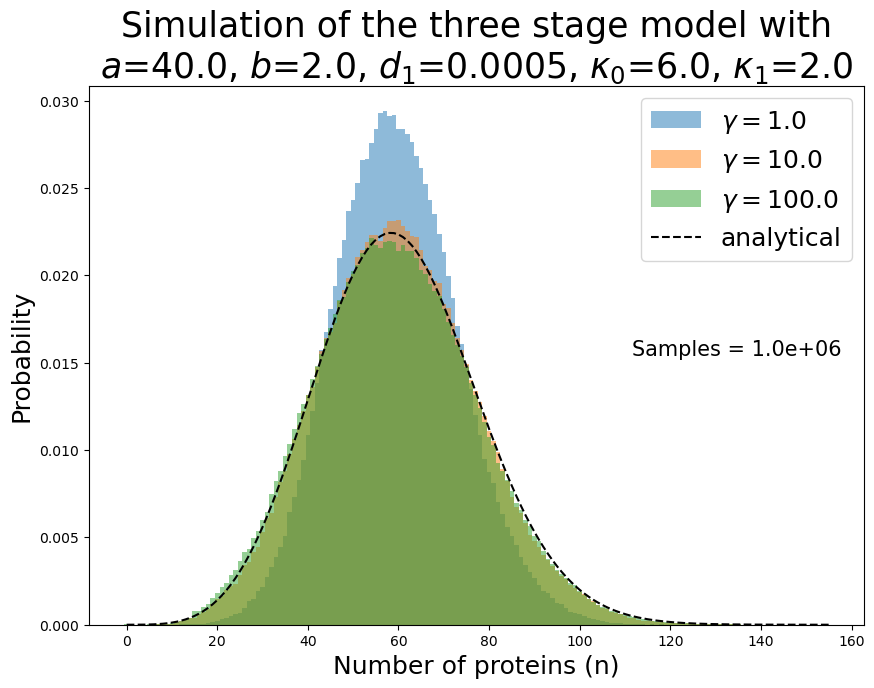

In [76]:
a_target = 40.0
N_target = int(1e6)
max_n = -1
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig3bcd/")):
    if not filename.startswith('.'):
        with open("results/fig3bcd/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(res["args_gamma_a_b_d1_k0_k1"][1], a_target) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1, k0, k1 = res["args_gamma_a_b_d1_k0_k1"]
            args = res["args"]
            tstat = res["tmax"]
            taustat = res["tau_max"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            # histogram
            h_, n_, _ = ax.hist(n_hist, bins=np.arange(start=-0.5, stop=max(n_hist)+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.5)
            max_n = max(max_n, max(n_hist))



# analytical plot
n0 = np.arange(max_n+10)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
ax.plot(n0, fn_analytical, "--", c="black", label="analytical")
ax.set_title("Simulation of the three stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\kappa_0$={k0}, $\kappa_1$={k1}")
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.text(0.7, 0.5, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/threestage_3b.jpg", dpi=150)

### Figure 3C

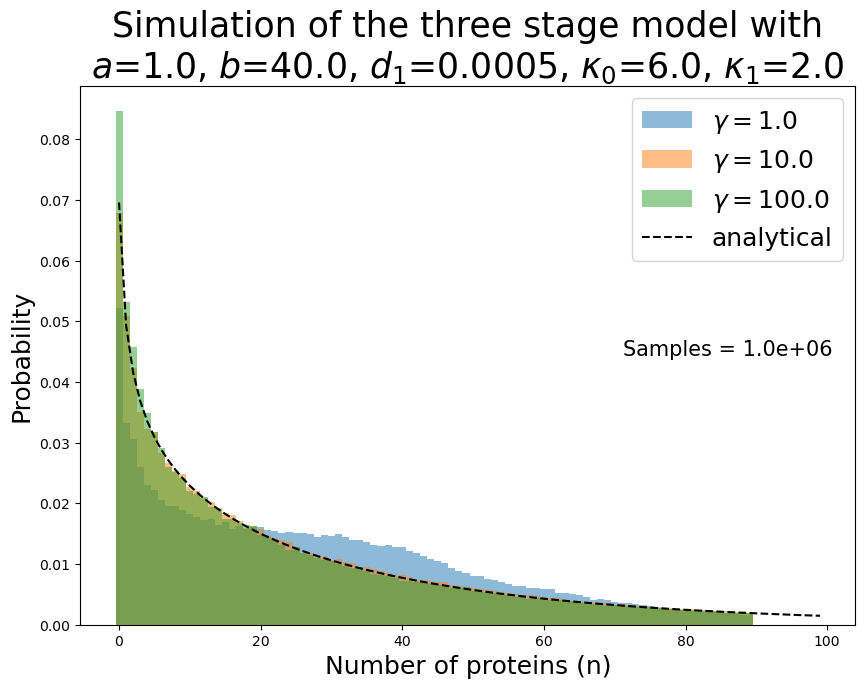

In [77]:
a_target = 1.0
N_target = int(1e6)
max_n = 90
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig3bcd/")):
    if not filename.startswith('.'):
        with open("results/fig3bcd/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(res["args_gamma_a_b_d1_k0_k1"][1], a_target) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1, k0, k1 = res["args_gamma_a_b_d1_k0_k1"]
            args = res["args"]
            tstat = res["tmax"]
            taustat = res["tau_max"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            # histogram
            h_, n_, _ = ax.hist(n_hist, bins=np.arange(start=-0.5, stop=max_n+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.5)


# analytical plot
n0 = np.arange(max_n+10)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
ax.plot(n0, fn_analytical, "--", c="black", label="analytical")
ax.set_title("Simulation of the three stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\kappa_0$={k0}, $\kappa_1$={k1}")
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.text(0.7, 0.5, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/threestage_3c.jpg", dpi=150)

### Figure 3D

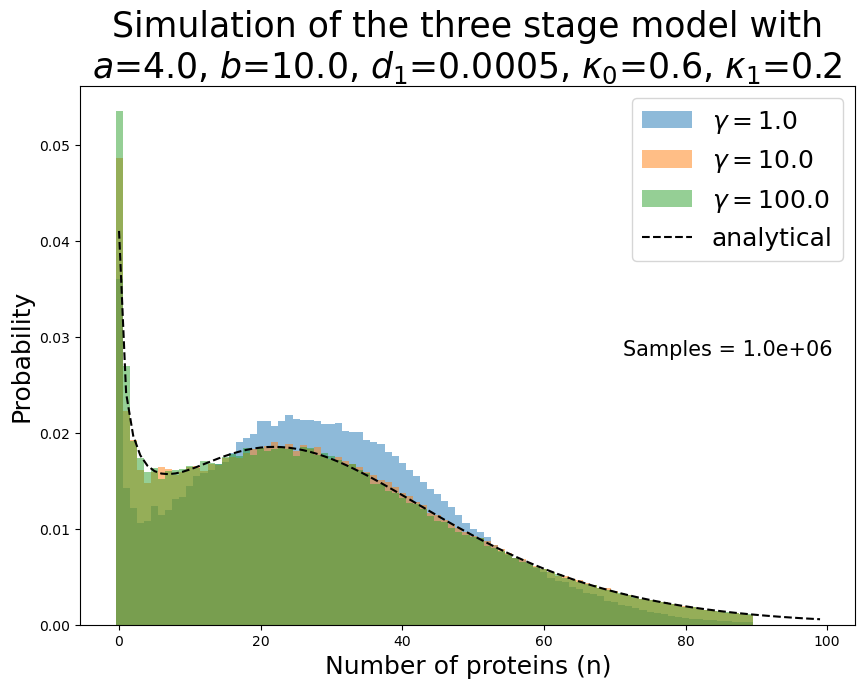

In [78]:
a_target = 4.0
N_target = int(1e6)
max_n = 90
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig3bcd/")):
    if not filename.startswith('.'):
        with open("results/fig3bcd/"+filename, 'rb') as file:
            res = pickle.load(file)

            if not np.isclose(res["args_gamma_a_b_d1_k0_k1"][1], a_target) or res["N_iters"] != N_target:
                continue
                
            # read arguments from pickle
            gamma, a, b, d1, k0, k1 = res["args_gamma_a_b_d1_k0_k1"]
            args = res["args"]
            tstat = res["tmax"]
            taustat = res["tau_max"]
            x0 = res["x0"]
            t0 = res["t0"]
            n_hist = res["n_hist"]

            # histogram
            h_, n_, _ = ax.hist(n_hist, bins=np.arange(start=-0.5, stop=max_n+0.5, step=1), density=True, label=rf"$\gamma = ${gamma}", alpha=0.5)


# analytical plot
n0 = np.arange(max_n+10)
fn_analytical = threestage.analytical_stationary(n0, args, normalize=True)
ax.plot(n0, fn_analytical, "--", c="black", label="analytical")
ax.set_title("Simulation of the three stage model with\n" + fr"$a$={a}, $b$={b}, $d_1$={d1}, $\kappa_0$={k0}, $\kappa_1$={k1}")
ax.set_xlabel("Number of proteins (n)")
ax.set_ylabel("Probability")
ax.text(0.7, 0.5, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/threestage_3d.jpg", dpi=150)

## Figure 3 extra

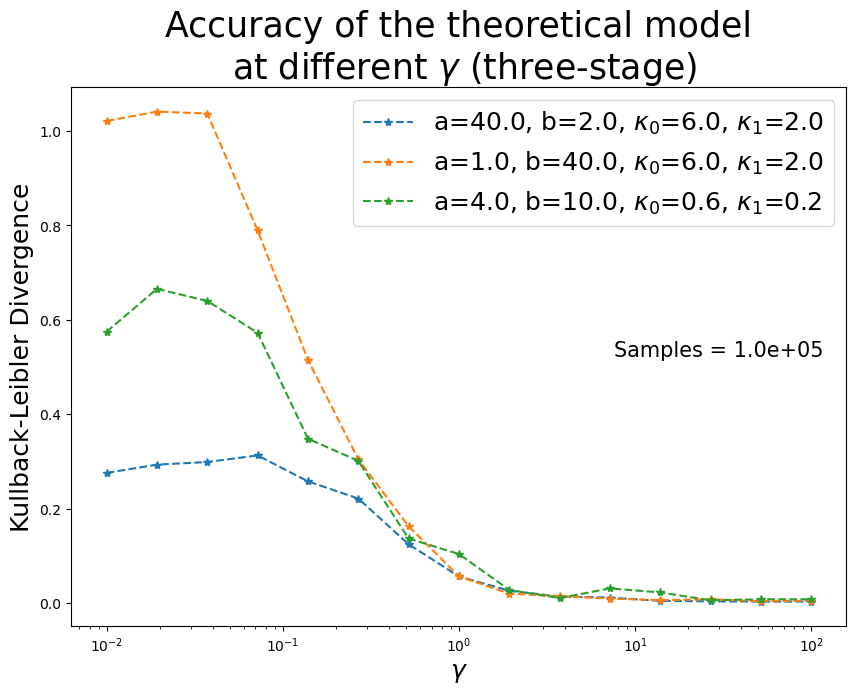

In [86]:
N_target = int(1e5)
KL_divs = {}
args_red_list = []
fig, ax = plt.subplots(1,1, figsize=(10,7))

for filename in sorted(os.listdir("results/fig3extra/")):
    if not filename.startswith('.'):
        with open("results/fig3extra/"+filename, 'rb') as file:
            res = pickle.load(file)

            if res["N_iters"] != N_target:
                continue

            # read arguments from pickle
            gamma, a, b, d1, k0, k1 = res["args_gamma_a_b_d1_k0_k1"]
            args = res["args"]
            tstat = res["tstat_"]
            taustat = res["tau_stat"]
            x0 = res["x0"]
            t0 = res["t0"]
            

            if f"{a}_{b}" not in KL_divs.keys():
                args_red_list.append((a, b, d1, k0, k1))
                KL_divs[f"{a}_{b}"] = {"D_KL":[], "gamma":[]}
            
            KL_divs[f"{a}_{b}"]["D_KL"].append(res["D_KL"])
            KL_divs[f"{a}_{b}"]["gamma"].append(gamma)

# plot curves
for a_,b_,_,k0_,k1_ in args_red_list:
    ax.plot(KL_divs[f"{a_}_{b_}"]["gamma"], KL_divs[f"{a_}_{b_}"]["D_KL"], "*--", label=f"a={a_}, b={b_}, $\kappa_0$={k0_}, $\kappa_1$={k1_}")

ax.set_title("Accuracy of the theoretical model\n at different $\gamma$ (three-stage)")
ax.set_xscale("log")
ax.set_xlabel("$\gamma$")
ax.set_ylabel("Kullback-Leibler Divergence")
ax.text(0.7, 0.5, f"Samples = {N_target:.1e}", fontsize=15, transform=ax.transAxes)
ax.legend()
fig.savefig("images/threestage_3extra.jpg", dpi=150)